In [1]:
#!pip install gensim
#!pip install nltk

In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 15
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [5]:
dataset_filename = os.listdir("input")[0]
dataset_path = os.path.join("input",dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: input/training.1600000.processed.noemoticon.csv


In [6]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [7]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [9]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 515 ms, sys: 30.5 ms, total: 546 ms
Wall time: 545 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

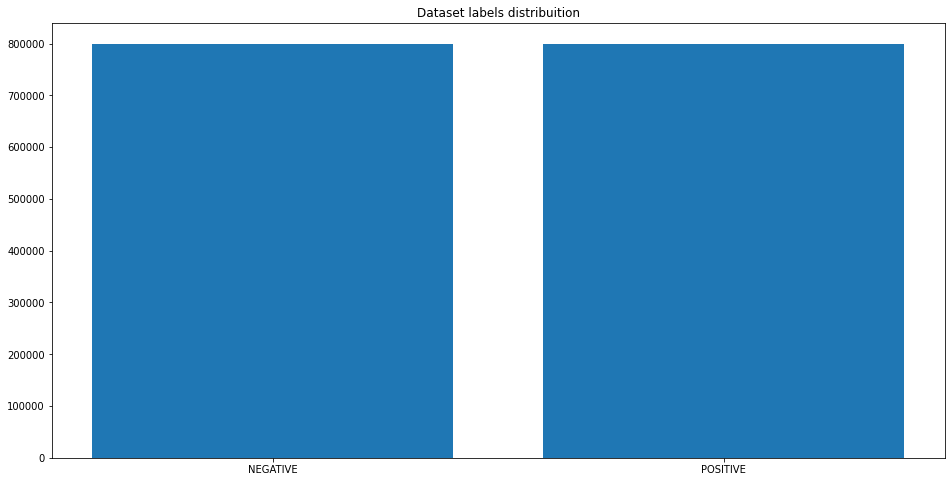

In [10]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [11]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [12]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [13]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 46 s, sys: 290 ms, total: 46.3 s
Wall time: 46.4 s


In [14]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [15]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.93 s, sys: 360 ms, total: 3.29 s
Wall time: 3.29 s


In [16]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

2022-08-03 17:18:05,772 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2022-08-03T17:18:05.771639', 'gensim': '4.2.0', 'python': '3.6.9 (default, Jan 26 2021, 15:33:00) \n[GCC 8.4.0]', 'platform': 'Linux-5.4.0-89-generic-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}


In [17]:
w2v_model.build_vocab(documents)

2022-08-03 17:18:05,779 : INFO : collecting all words and their counts
2022-08-03 17:18:05,780 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-08-03 17:18:05,807 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2022-08-03 17:18:05,830 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2022-08-03 17:18:05,854 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2022-08-03 17:18:05,876 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2022-08-03 17:18:05,900 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2022-08-03 17:18:05,923 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2022-08-03 17:18:05,944 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2022-08-03 17:18:05,965 : INFO : PROGRESS: at s

In [18]:
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [19]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2022-08-03 17:18:10,637 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2022-08-03T17:18:10.637778', 'gensim': '4.2.0', 'python': '3.6.9 (default, Jan 26 2021, 15:33:00) \n[GCC 8.4.0]', 'platform': 'Linux-5.4.0-89-generic-x86_64-with-Ubuntu-18.04-bionic', 'event': 'train'}
2022-08-03 17:18:11,660 : INFO : EPOCH 0 - PROGRESS: at 9.45% examples, 765433 words/s, in_qsize 16, out_qsize 0
2022-08-03 17:18:12,672 : INFO : EPOCH 0 - PROGRESS: at 19.40% examples, 787674 words/s, in_qsize 15, out_qsize 0
2022-08-03 17:18:13,691 : INFO : EPOCH 0 - PROGRESS: at 31.97% examples, 863615 words/s, in_qsize 15, out_qsize 0
2022-08-03 17:18:14,701 : INFO : EPOCH 0 - PROGRESS: at 43.75% examples, 887909 words/s, in_qsize 16, out_qsize 1
2022-08-03 17:18:15,705 : INFO : EPOCH 0 - PROGRESS: at 56.51% examples, 919495 words/s, in_qsize 16, out_qsize 0
2022-08-03

CPU times: user 23min 27s, sys: 6.09 s, total: 23min 33s
Wall time: 4min 41s


(263126747, 295270528)

In [20]:
w2v_model.wv.most_similar("love")

[('luv', 0.5689023733139038),
 ('loves', 0.5487812161445618),
 ('loved', 0.5396385788917542),
 ('adore', 0.5287768840789795),
 ('amazing', 0.5131515860557556),
 ('looove', 0.49581748247146606),
 ('loveee', 0.47624102234840393),
 ('awesome', 0.46104368567466736),
 ('miss', 0.433794766664505),
 ('lovee', 0.4335745573043823)]

In [21]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 18.6 s, sys: 449 ms, total: 19.1 s
Wall time: 18.6 s


In [22]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 28.5 s, sys: 820 ms, total: 29.3 s
Wall time: 29.3 s


In [23]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [24]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [25]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [26]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [27]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [28]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [29]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2022-08-03 17:23:43,679 : WARNING : Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [30]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [31]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [32]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/15
1125/1125 [==============================] - 543s 480ms/step - loss: 0.5255 - accuracy: 0.7331 - val_loss: 0.4669 - val_accuracy: 0.7786
Epoch 2/15
1125/1125 [==============================] - 537s 477ms/step - loss: 0.4796 - accuracy: 0.7667 - val_loss: 0.4562 - val_accuracy: 0.7843
Epoch 3/15
1125/1125 [==============================] - 536s 477ms/step - loss: 0.4713 - accuracy: 0.7718 - val_loss: 0.4522 - val_accuracy: 0.7865
Epoch 4/15
1125/1125 [==============================] - 538s 478ms/step - loss: 0.4683 - accuracy: 0.7740 - val_loss: 0.4519 - val_accuracy: 0.7877
Epoch 5/15
1125/1125 [==============================] - 542s 482ms/step - loss: 0.4648 - accuracy: 0.7761 - val_loss: 0.4510 - val_accuracy: 0.7886
Epoch 6/15
1125/1125 [==============================] - 541s 481ms/step - loss: 0.4629 - accuracy: 0.7777 - val_loss: 0.4476 - val_accuracy: 0.7887
Epoch 7/15
1125/1125 [==============================] - 541s 481ms/step - loss: 0.4615 - accuracy: 0.7782 - val_

In [33]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 47s 148ms/step - loss: 0.4425 - accuracy: 0.7926

ACCURACY: 0.7926375269889832
LOSS: 0.4424968659877777
CPU times: user 1min 20s, sys: 1.63 s, total: 1min 21s
Wall time: 46.9 s


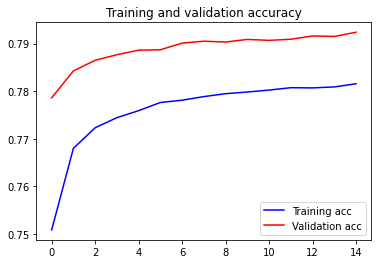

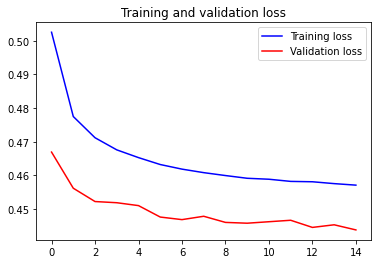

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [35]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [36]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [37]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9730955362319946,
 'elapsed_time': 0.33366918563842773}

In [38]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.012879985384643078,
 'elapsed_time': 0.10443353652954102}

In [39]:
predict("i don't know what i'm doing")

{'label': 'NEGATIVE',
 'score': 0.35166487097740173,
 'elapsed_time': 0.10974621772766113}

In [40]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 42s 979ms/step
CPU times: user 1min 9s, sys: 12.4 s, total: 1min 21s
Wall time: 42.5 s


In [41]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

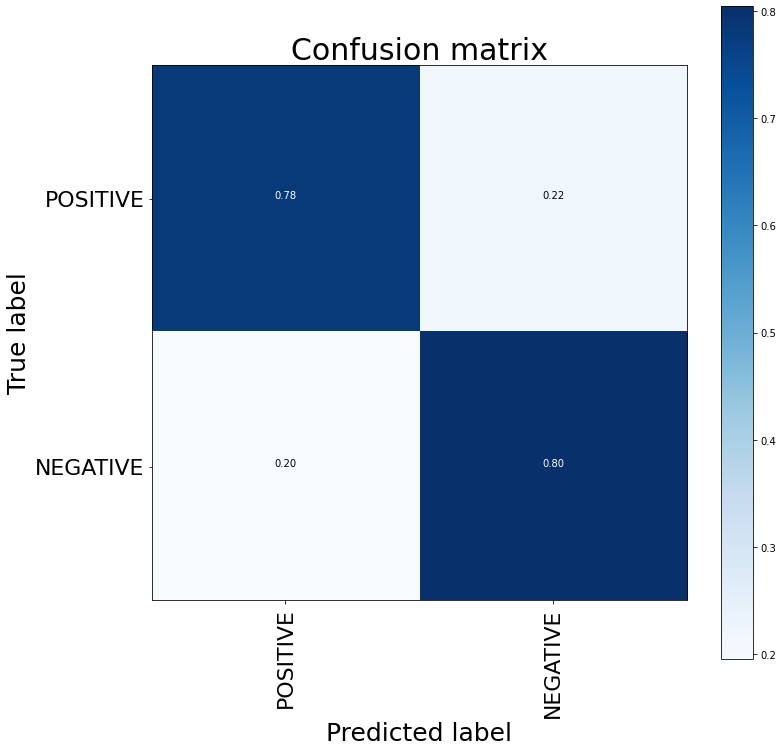

CPU times: user 1.08 s, sys: 72.3 ms, total: 1.15 s
Wall time: 1.15 s


In [42]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [43]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.78      0.79    159494
    POSITIVE       0.79      0.80      0.80    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [44]:
accuracy_score(y_test_1d, y_pred_1d)

0.7926375

In [45]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2022-08-03 19:40:03,236 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'model.w2v', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-08-03T19:40:03.236338', 'gensim': '4.2.0', 'python': '3.6.9 (default, Jan 26 2021, 15:33:00) \n[GCC 8.4.0]', 'platform': 'Linux-5.4.0-89-generic-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2022-08-03 19:40:03,237 : INFO : not storing attribute cum_table
2022-08-03 19:40:03,544 : INFO : saved model.w2v
